In [1]:
import pandas as pd

from matplotlib import pyplot as plt
from pymgrid import Microgrid
from pymgrid.algos import RuleBasedControl

In [2]:
import numpy as np
import yaml

from pymgrid.microgrid import DEFAULT_HORIZON
from pymgrid.modules.base import BaseTimeSeriesMicrogridModule


class RenewableModuleCustom(BaseTimeSeriesMicrogridModule):
    """
    A renewable energy module.

    The classic examples of renewables are photovoltaics (PV) and wind turbines.

    Parameters
    ----------
    time_series : array-like, shape (n_steps, )
        Time series of renewable production.

    forecaster : callable, float, "oracle", or None, default None.
        Function that gives a forecast n-steps ahead.

        * If ``callable``, must take as arguments ``(val_c: float, val_{c+n}: float, n: int)``, where

          * ``val_c`` is the current value in the time series: ``self.time_series[self.current_step]``

          * ``val_{c+n}`` is the value in the time series n steps in the future

          * n is the number of steps in the future at which we are forecasting.

          The output ``forecast = forecaster(val_c, val_{c+n}, n)`` must have the same sign
          as the inputs ``val_c`` and ``val_{c+n}``.

        * If ``float``, serves as a standard deviation for a mean-zero gaussian noise function
          that is added to the true value.

        * If ``"oracle"``, gives a perfect forecast.

        * If ``None``, no forecast.

    forecast_horizon : int.
        Number of steps in the future to forecast. If forecaster is None, ignored and 0 is returned.

    forecaster_increase_uncertainty : bool, default False
        Whether to increase uncertainty for farther-out dates if using a GaussianNoiseForecaster. Ignored otherwise.

    provided_energy_name: str, default "renewable_used"
        Name of the energy provided by this module, to be used in logging.

    raise_errors : bool, default False
        Whether to raise errors if bounds are exceeded in an action.
        If False, actions are clipped to the limit possible.

    """
    module_type = ('renewable', 'flex')
    yaml_tag = u"!RenewableModule"
    yaml_loader = yaml.SafeLoader
    yaml_dumper = yaml.SafeDumper

    state_components = np.array(["renewable"], dtype=object)

    def __init__(self,
                 time_series,
                 raise_errors=False,
                 forecaster=None,
                 forecast_horizon=DEFAULT_HORIZON,
                 forecaster_increase_uncertainty=False,
                 forecaster_relative_noise=False,
                 initial_step=0,
                 final_step=-1,
                 normalized_action_bounds=(0, 1),
                 provided_energy_name='renewable_used',
                 operating_cost=0.0):
        super().__init__(
            time_series,
            raise_errors,
            forecaster=forecaster,
            forecast_horizon=forecast_horizon,
            forecaster_increase_uncertainty=forecaster_increase_uncertainty,
            forecaster_relative_noise=forecaster_relative_noise,
            initial_step=initial_step,
            final_step=final_step,
            normalized_action_bounds=normalized_action_bounds,
            provided_energy_name=provided_energy_name,
            absorbed_energy_name=None
        )
        self.operating_cost = operating_cost

    def update(self, external_energy_change, as_source=False, as_sink=False):
        assert as_source, f'Class {self.__class__.__name__} can only be used as a source.'
        assert external_energy_change <= self.current_renewable, f'Cannot provide more than {self.current_renewable}'

        info = {'provided_energy': external_energy_change,
                'curtailment': self.current_renewable-external_energy_change}

        reward = -1.0 * self.operating_cost * external_energy_change

        return reward, self._done(), info

    @property
    def max_production(self):
        return self.current_renewable

    @property
    def current_renewable(self):
        """
        Current renewable production.

        Returns
        -------
        renewable : float
            Renewable production.

        """
        return self._time_series[self._current_step].item()

    @property
    def is_source(self):
        return True

    @property
    def production_marginal_cost(self):
        return self.operating_cost

## MicroGrid 25 Households

In [3]:
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule,
    GensetModule)

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

battery = BatteryModule(
    min_capacity=15,
    max_capacity=285,
    max_charge=2.5,
    max_discharge=2.5,
    efficiency=0.99,
    battery_cost_cycle=0.95,
    init_soc=0.1
)
print(battery)

gas_turbine_generator = GensetModule(
    running_min_production=0,
    running_max_production=600,
    genset_cost=0.55
)

print(gas_turbine_generator)

data = pd.read_csv("../data/EnergyGenerationRenewable_round.csv")
time_solar = data["Solar Generation"].values
time_wind = data["Wind Generation"].values

solar_pv = RenewableModuleCustom(
    time_series=time_solar,
    operating_cost=0.15
)

print(solar_pv)

wind_turbine = RenewableModuleCustom(
    time_series=time_wind,
    operating_cost=0.085
)

print(wind_turbine)

buy_price = pd.read_csv("../data/rate_consumption_charge.csv")["Grid Elecricity Price（$/kWh）"].values
sell_price = np.ones(len(buy_price)) * .2
co2 = np.zeros(len(buy_price))

time_grid = np.concatenate([buy_price[:, None], sell_price[:, None], co2[:, None]], axis=1)

grid = GridModule(
    time_series=time_grid,
    max_export=10000,
    max_import=10000
)

time_load = pd.read_csv("../data/Load25Households.csv")["load"].values[:8640]

load = LoadModule(
    time_series=time_load
)

print(load)

modules = [
    battery,
    gas_turbine_generator,
    ("solar_pv", solar_pv),
    ("wind_turbine", wind_turbine),
    grid,
    load
]

BatteryModule(min_capacity=15, max_capacity=285, max_charge=2.5, max_discharge=2.5, efficiency=0.99, battery_cost_cycle=0.95, battery_transition_model=BatteryTransitionModel(), init_charge=None, init_soc=0.1, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False)
GensetModule(running_min_production=0, running_max_production=600, genset_cost=0.55, co2_per_unit=0.0, cost_per_unit_co2=0.0, start_up_time=0, wind_down_time=0, allow_abortion=True, init_start_up=True, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False, provided_energy_name=genset_production)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, forecaster_relative_noise=False, initial_step=0, final_step=8640, normalized_action_bounds=<class 'tuple'>, provided_energy_name=renewable_used, operating_cost=0.15)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise

### Random Policy

In [4]:
microgrid = Microgrid(modules=modules)

In [5]:
microgrid.get_cost_info()

{'load': [{'production_marginal_cost': 0.0, 'absorption_marginal_cost': 0.0}],
 'solar_pv': [{'production_marginal_cost': 0.15,
   'absorption_marginal_cost': 0.0}],
 'wind_turbine': [{'production_marginal_cost': 0.085,
   'absorption_marginal_cost': 0.0}],
 'balancing': [{'production_marginal_cost': 10.0,
   'absorption_marginal_cost': 2.0}],
 'genset': [{'production_marginal_cost': 0.55,
   'absorption_marginal_cost': 0.0}],
 'battery': [{'production_marginal_cost': 0.95,
   'absorption_marginal_cost': 0.95}],
 'grid': [{'production_marginal_cost': 0.06, 'absorption_marginal_cost': 0.2}]}

In [6]:
for _ in range(8640):
    microgrid.run(microgrid.sample_action())

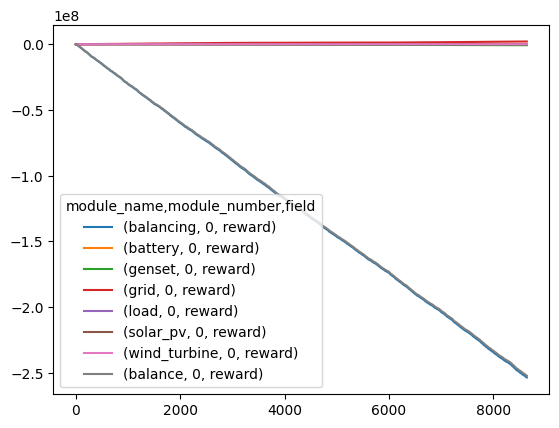

In [7]:
microgrid.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
plt.show()

In [8]:
microgrid.log.to_csv("random_25.csv")

In [9]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 26)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

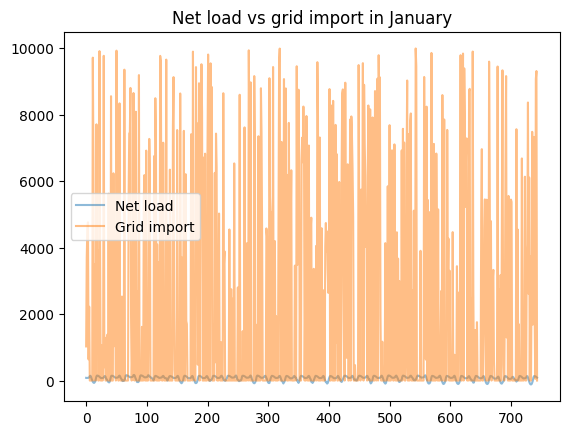

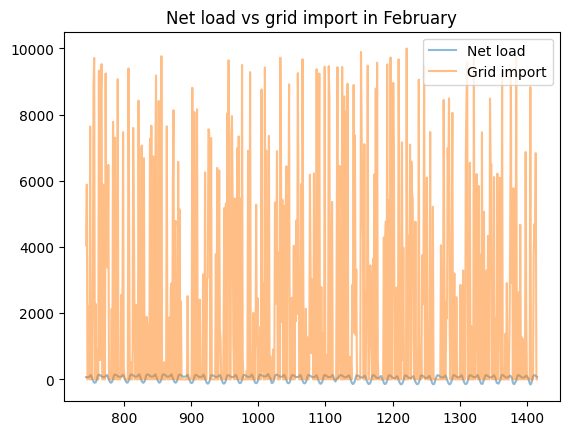

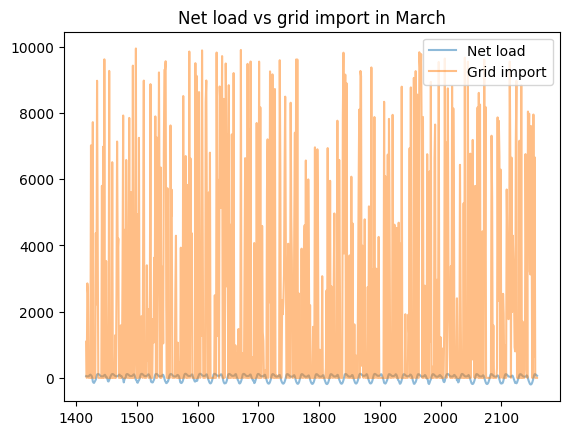

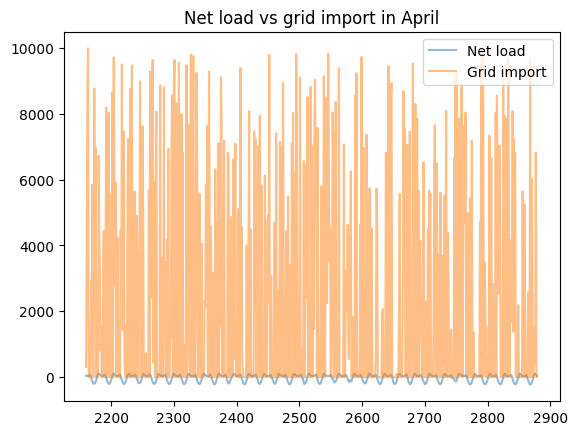

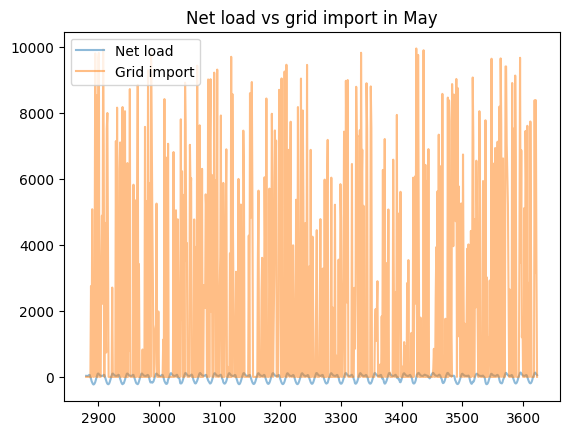

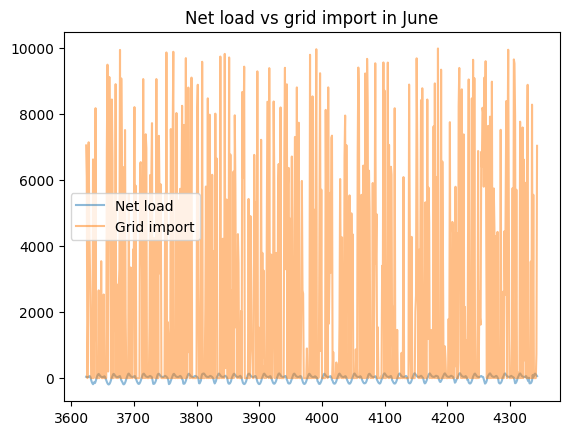

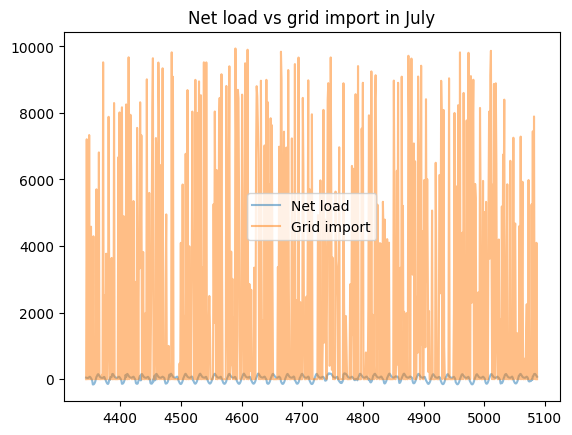

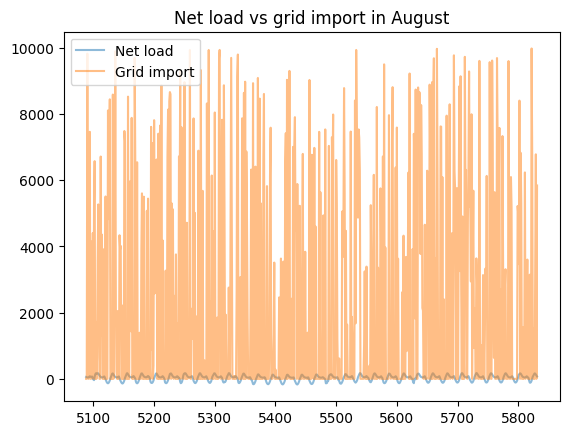

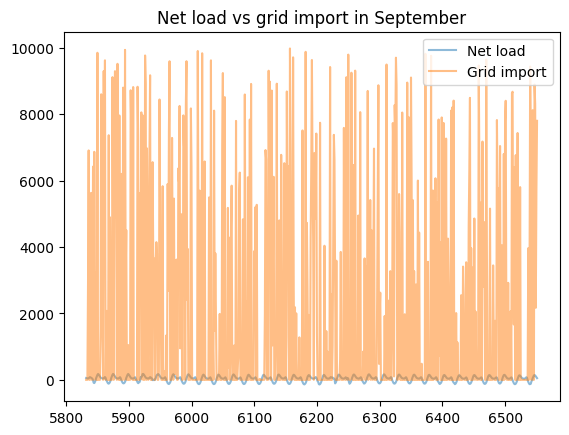

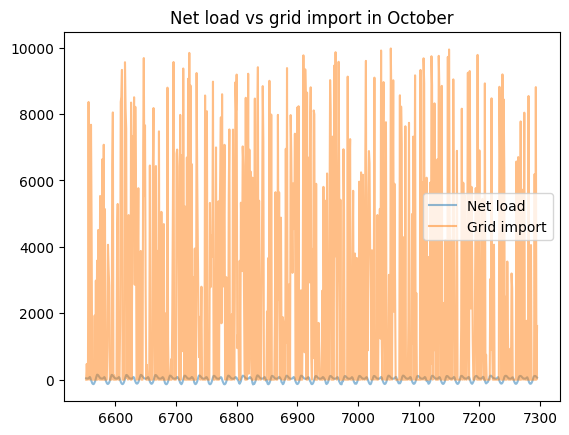

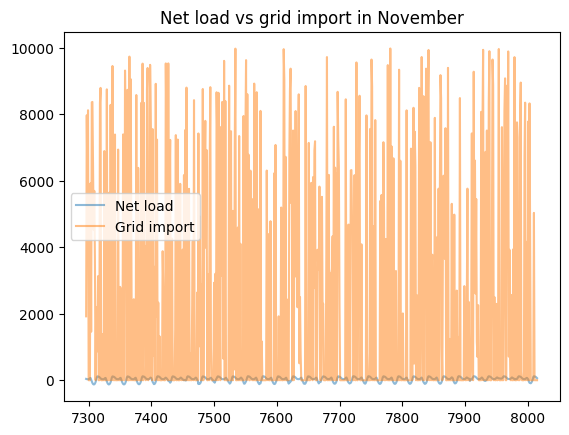

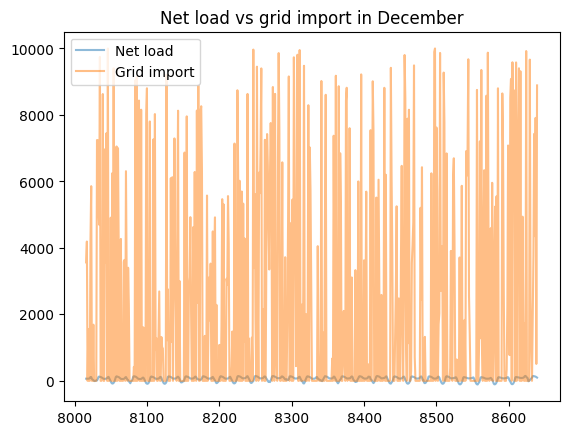

In [10]:
load_less_renewable_available = microgrid.log[('load', 0, 'load_met')] - microgrid.log[('solar_pv', 0, 'renewable_current')]
grid_import = microgrid.log[('grid', 0, 'grid_import')]

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load_less_renewable_available, grid_import],
              keys=['Net load', 'Grid import'],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

### Rule-based

In [11]:
microgrid = Microgrid(modules=modules)
rbc = RuleBasedControl(microgrid)

In [12]:
rbc.reset()
rbc_result = rbc.run()

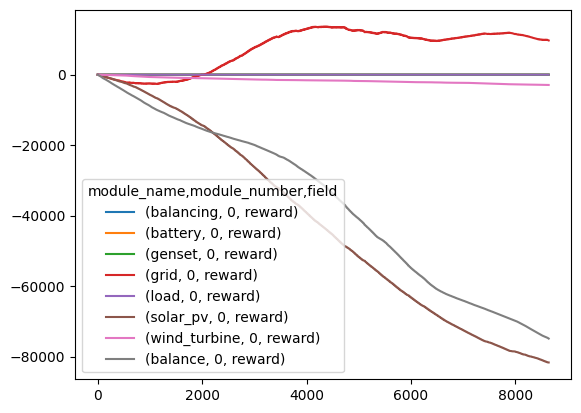

In [13]:
rbc_result.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
plt.show()

In [14]:
print(f"Total overgeneration or loss load costs over the course of the year:\n\
{rbc_result.loc[:, pd.IndexSlice['balancing', :, 'reward']].sum().item()}")

Total overgeneration or loss load costs over the course of the year:
-1.4023863342295384e-10


In [15]:
rbc_result.to_csv("rbc_25.csv")

In [16]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 26)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

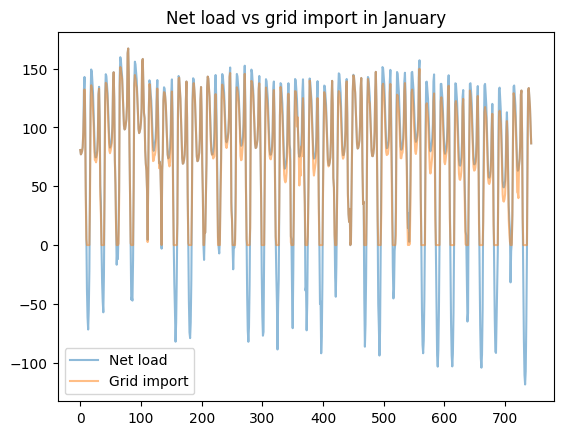

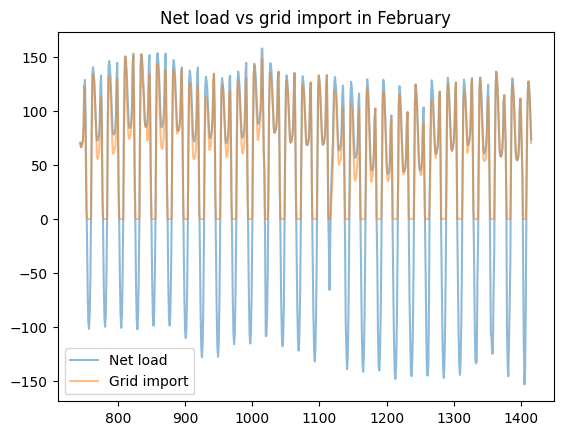

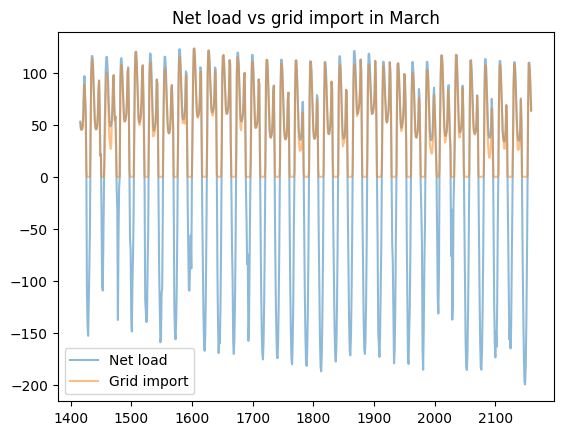

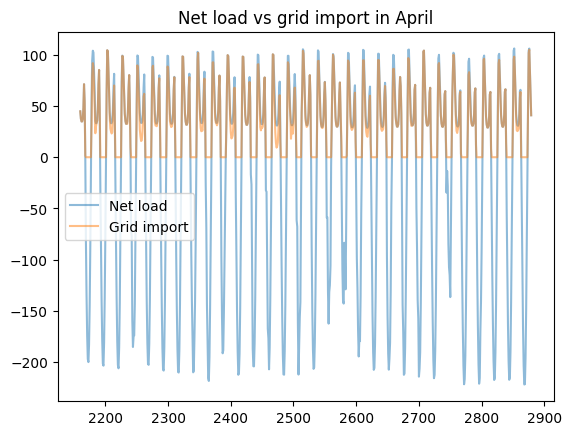

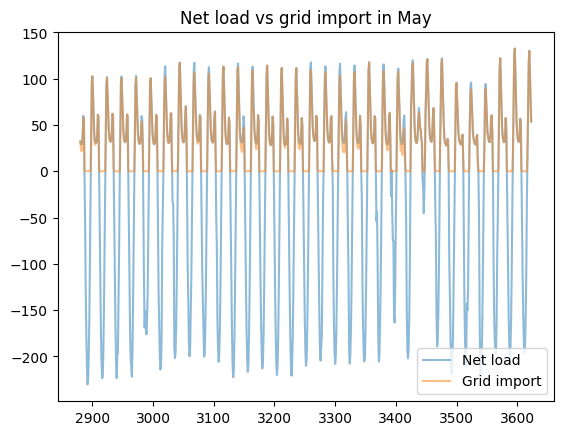

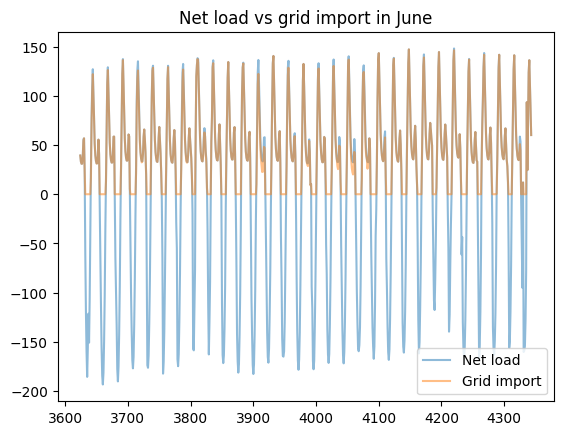

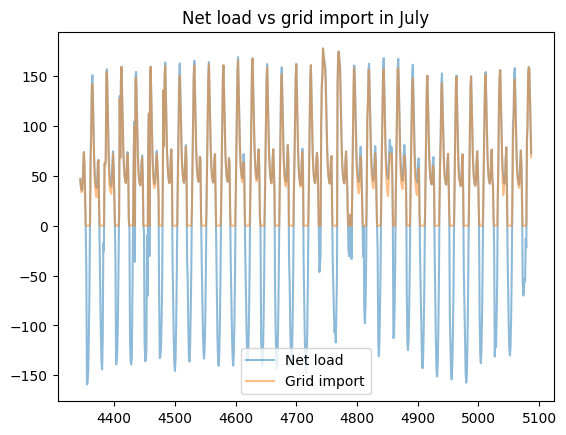

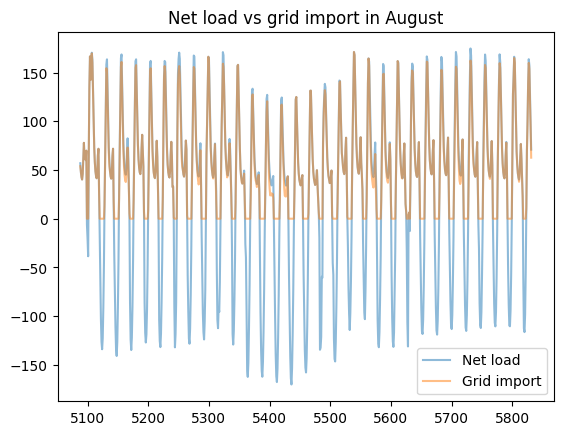

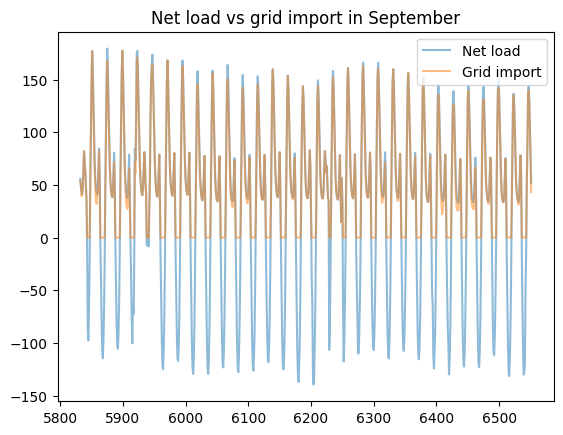

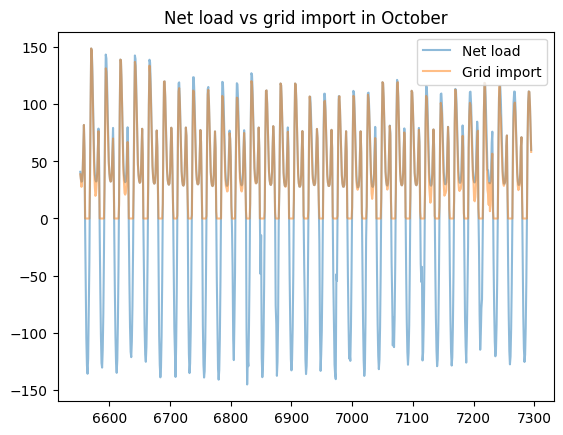

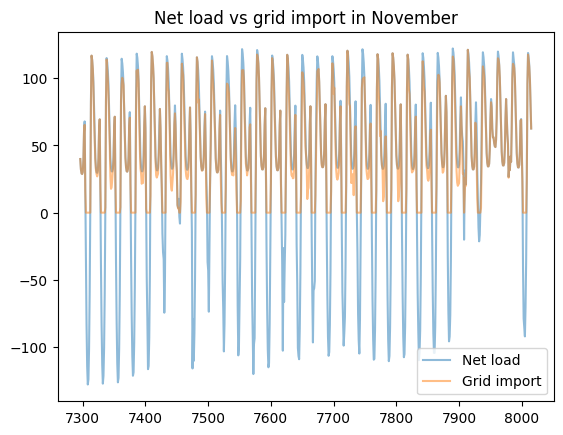

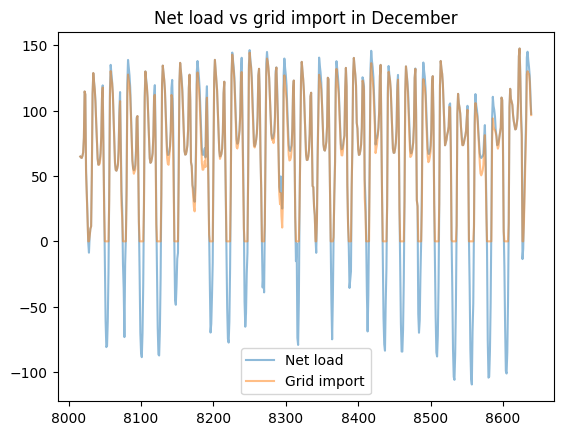

In [17]:
load_less_renewable_available = rbc_result[('load', 0, 'load_met')] - rbc_result[('solar_pv', 0, 'renewable_current')]
grid_import = rbc_result[('grid', 0, 'grid_import')]

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load_less_renewable_available, grid_import],
              keys=['Net load', 'Grid import'],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

### Reinforcement Learning

## MicroGrid 100 Households

In [18]:
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule,
    GensetModule)

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

battery = BatteryModule(
    min_capacity=15,
    max_capacity=285,
    max_charge=2.5,
    max_discharge=2.5,
    efficiency=0.99,
    battery_cost_cycle=0.95,
    init_soc=0.1
)
print(battery)

gas_turbine_generator = GensetModule(
    running_min_production=0,
    running_max_production=600,
    genset_cost=0.55
)

print(gas_turbine_generator)

data = pd.read_csv("../data/EnergyGenerationRenewable_round.csv")
time_solar = data["Solar Generation"].values
time_wind = data["Wind Generation"].values

solar_pv = RenewableModuleCustom(
    time_series=time_solar,
    operating_cost=0.15
)

print(solar_pv)

wind_turbine = RenewableModuleCustom(
    time_series=time_wind,
    operating_cost=0.085
)

print(wind_turbine)

buy_price = pd.read_csv("../data/rate_consumption_charge.csv")["Grid Elecricity Price（$/kWh）"].values
sell_price = np.ones(len(buy_price)) * .2
co2 = np.zeros(len(buy_price))

time_grid = np.concatenate([buy_price[:, None], sell_price[:, None], co2[:, None]], axis=1)

grid = GridModule(
    time_series=time_grid,
    max_export=10000,
    max_import=10000
)

time_load = pd.read_csv("../data/Load100Households.csv")["load"].values[:8640]

load = LoadModule(
    time_series=time_load
)

print(load)

modules = [
    battery,
    gas_turbine_generator,
    ("solar_pv", solar_pv),
    ("wind_turbine", wind_turbine),
    grid,
    load
]

BatteryModule(min_capacity=15, max_capacity=285, max_charge=2.5, max_discharge=2.5, efficiency=0.99, battery_cost_cycle=0.95, battery_transition_model=BatteryTransitionModel(), init_charge=None, init_soc=0.1, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False)
GensetModule(running_min_production=0, running_max_production=600, genset_cost=0.55, co2_per_unit=0.0, cost_per_unit_co2=0.0, start_up_time=0, wind_down_time=0, allow_abortion=True, init_start_up=True, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False, provided_energy_name=genset_production)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, forecaster_relative_noise=False, initial_step=0, final_step=8640, normalized_action_bounds=<class 'tuple'>, provided_energy_name=renewable_used, operating_cost=0.15)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise

### Random Policy

In [19]:
microgrid = Microgrid(modules=modules)

In [20]:
microgrid.get_cost_info()

{'load': [{'production_marginal_cost': 0.0, 'absorption_marginal_cost': 0.0}],
 'solar_pv': [{'production_marginal_cost': 0.15,
   'absorption_marginal_cost': 0.0}],
 'wind_turbine': [{'production_marginal_cost': 0.085,
   'absorption_marginal_cost': 0.0}],
 'balancing': [{'production_marginal_cost': 10.0,
   'absorption_marginal_cost': 2.0}],
 'genset': [{'production_marginal_cost': 0.55,
   'absorption_marginal_cost': 0.0}],
 'battery': [{'production_marginal_cost': 0.95,
   'absorption_marginal_cost': 0.95}],
 'grid': [{'production_marginal_cost': 0.06, 'absorption_marginal_cost': 0.2}]}

In [21]:
for _ in range(8640):
    microgrid.run(microgrid.sample_action())

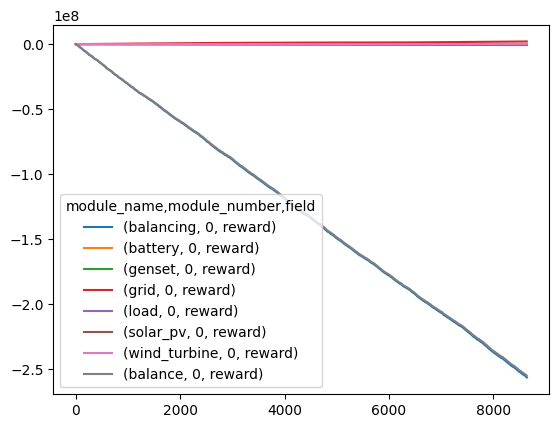

In [22]:
microgrid.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
plt.show()

In [23]:
microgrid.log.to_csv("random_100.csv")

In [24]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 26)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

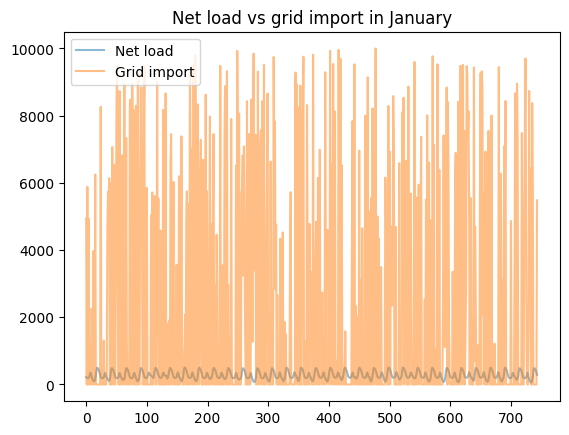

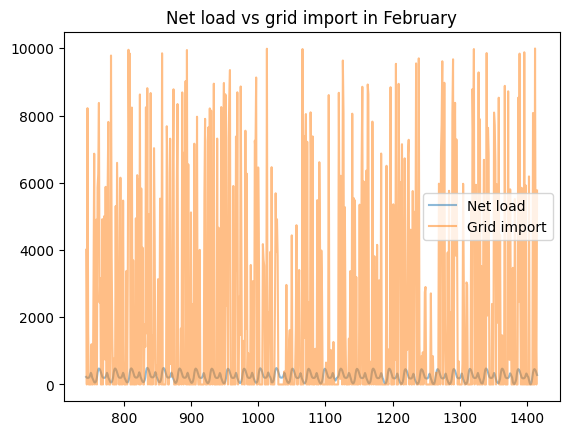

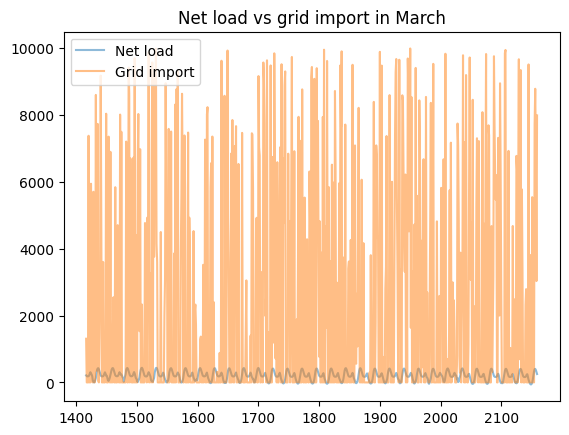

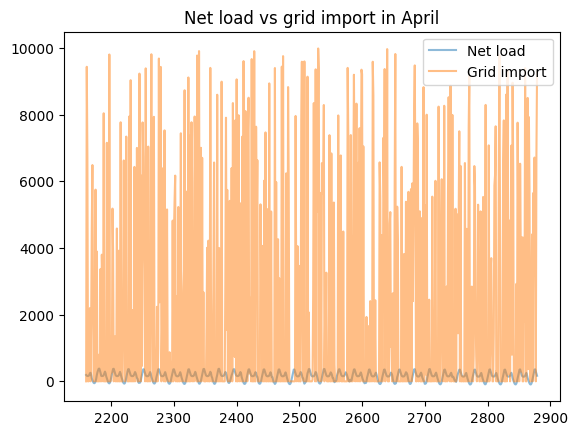

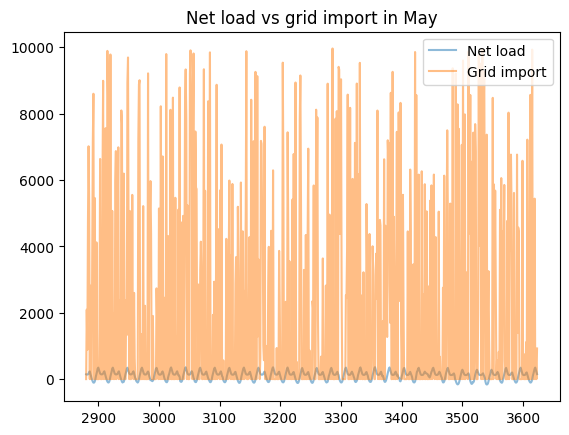

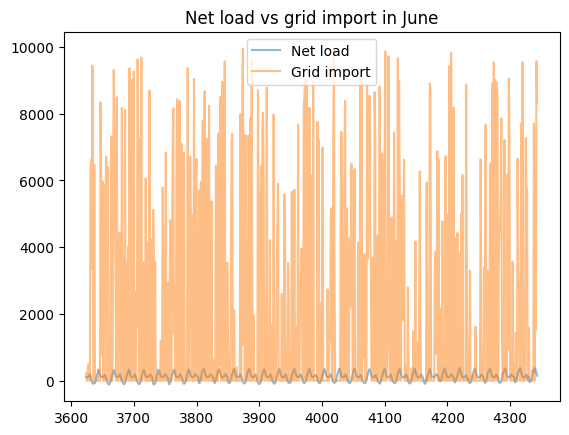

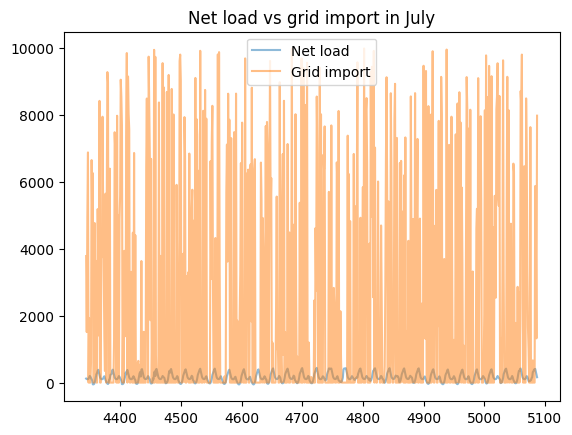

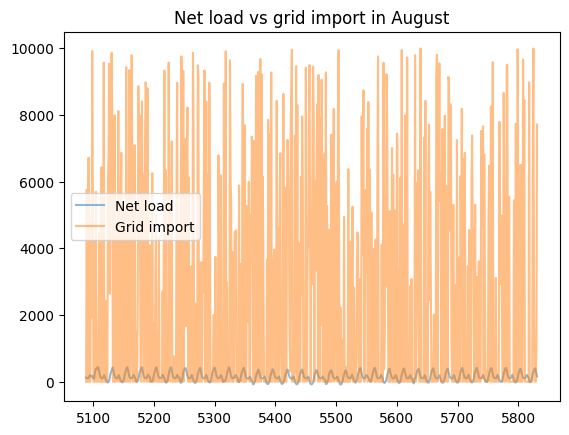

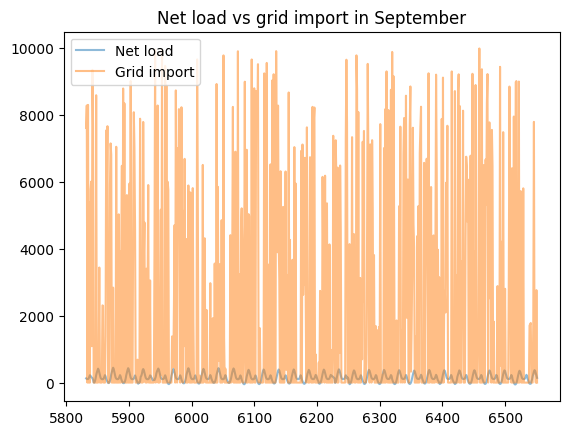

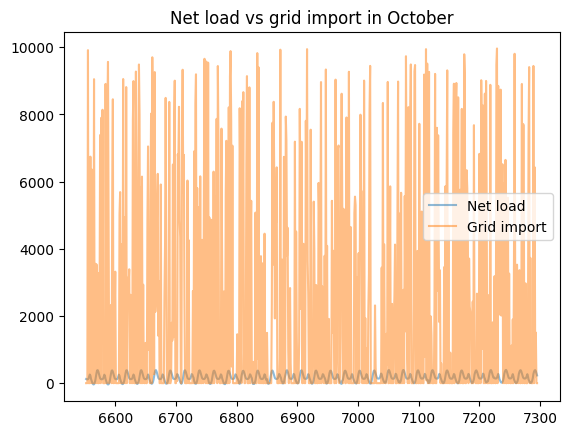

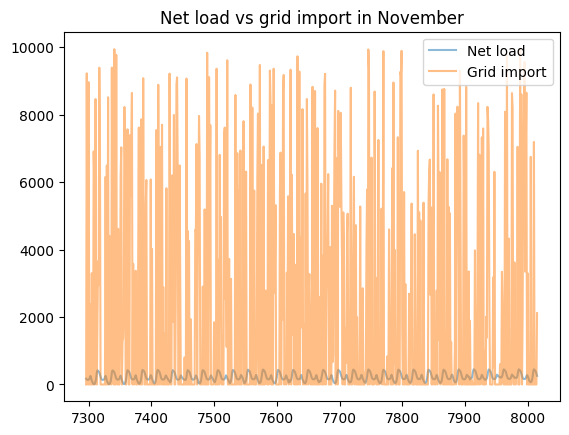

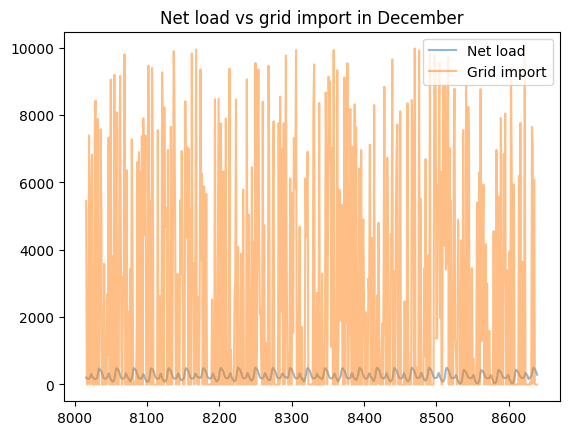

In [25]:
load_less_renewable_available = microgrid.log[('load', 0, 'load_met')] - microgrid.log[('solar_pv', 0, 'renewable_current')]
grid_import = microgrid.log[('grid', 0, 'grid_import')]

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load_less_renewable_available, grid_import],
              keys=['Net load', 'Grid import'],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

### Rule-based

In [26]:
microgrid = Microgrid(modules=modules)
rbc = RuleBasedControl(microgrid)

In [27]:
rbc.reset()
rbc_result = rbc.run()

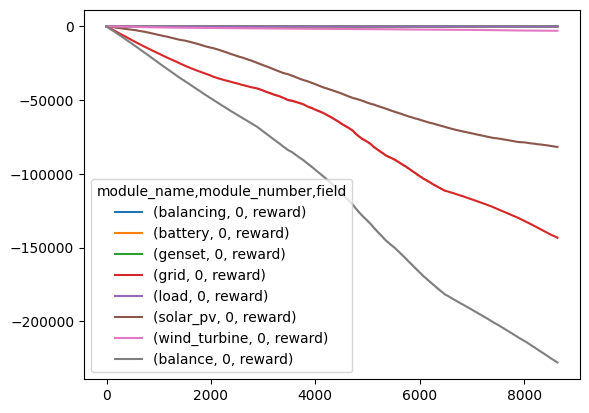

In [28]:
rbc_result.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
plt.show()

In [29]:
print(f"Total overgeneration or loss load costs over the course of the year:\n\
{rbc_result.loc[:, pd.IndexSlice['balancing', :, 'reward']].sum().item()}")

Total overgeneration or loss load costs over the course of the year:
-3.1825387187796664e-10


In [30]:
rbc_result.to_csv("rbc_100.csv")

In [31]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 26)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

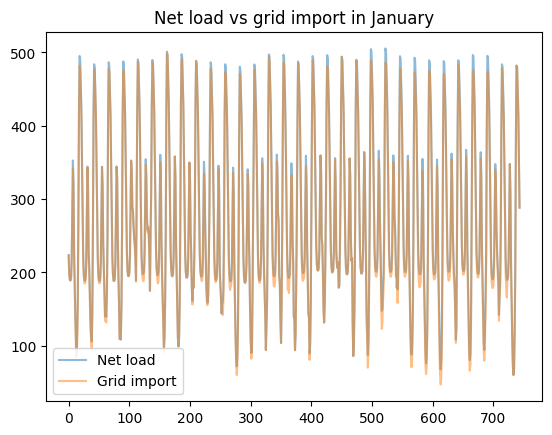

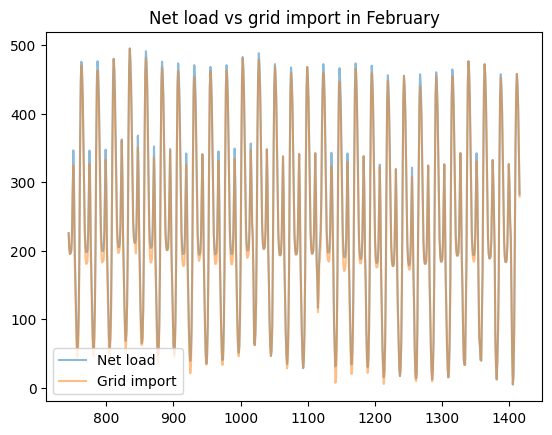

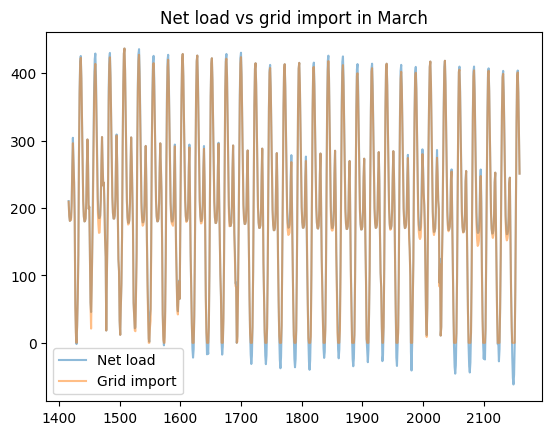

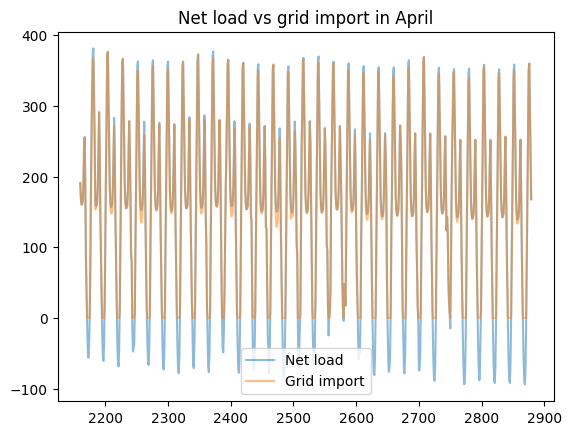

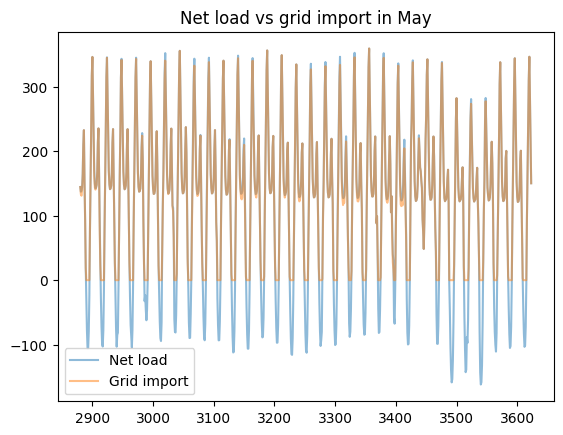

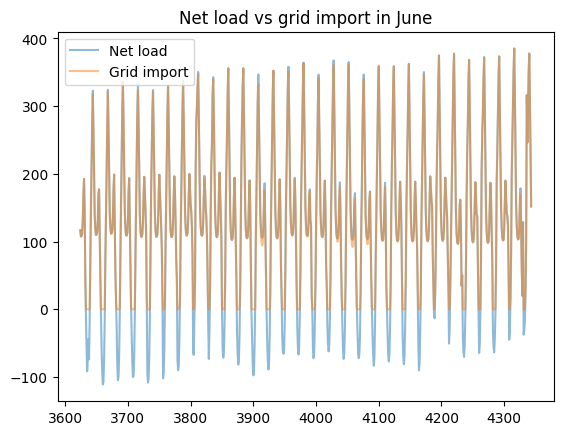

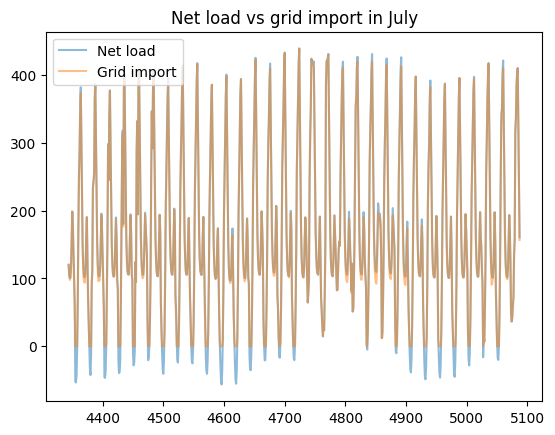

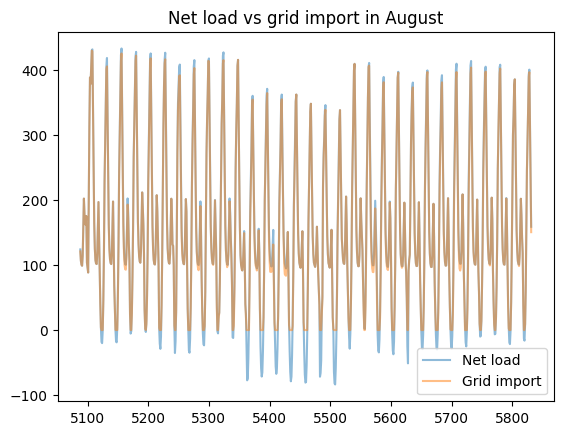

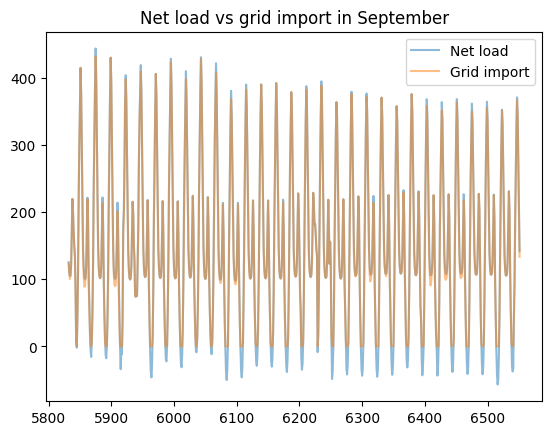

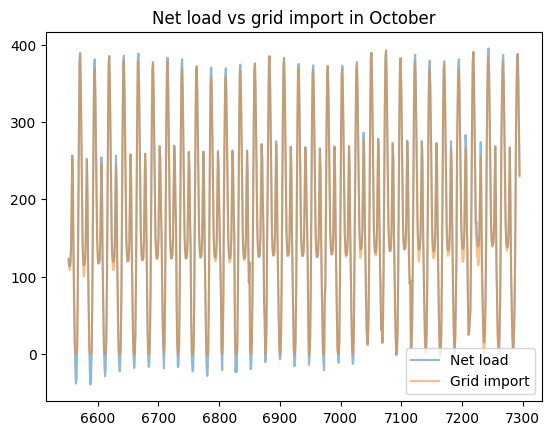

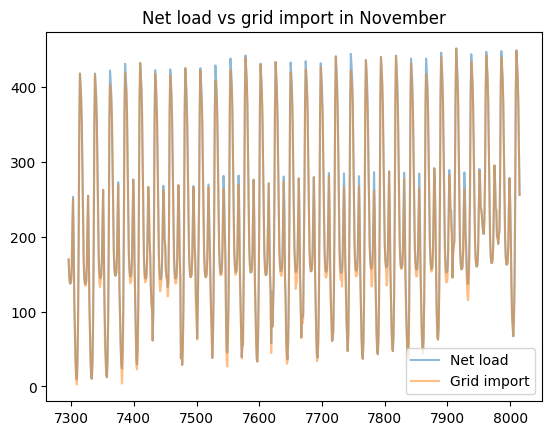

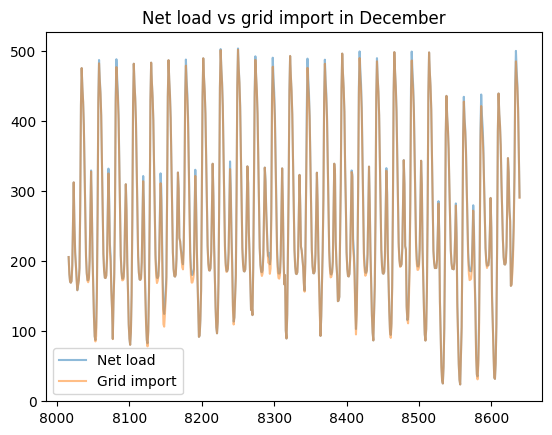

In [32]:
load_less_renewable_available = rbc_result[('load', 0, 'load_met')] - rbc_result[('solar_pv', 0, 'renewable_current')]
grid_import = rbc_result[('grid', 0, 'grid_import')]

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load_less_renewable_available, grid_import],
              keys=['Net load', 'Grid import'],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

### Reinforcement Learning

## MicroGrid 272 Households

In [33]:
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule,
    GensetModule)

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

battery = BatteryModule(
    min_capacity=15,
    max_capacity=285,
    max_charge=2.5,
    max_discharge=2.5,
    efficiency=0.99,
    battery_cost_cycle=0.95,
    init_soc=0.1
)
print(battery)

gas_turbine_generator = GensetModule(
    running_min_production=0,
    running_max_production=600,
    genset_cost=0.55
)

print(gas_turbine_generator)

data = pd.read_csv("../data/EnergyGenerationRenewable_round.csv")
time_solar = data["Solar Generation"].values
time_wind = data["Wind Generation"].values

solar_pv = RenewableModuleCustom(
    time_series=time_solar,
    operating_cost=0.15
)

print(solar_pv)

wind_turbine = RenewableModuleCustom(
    time_series=time_wind,
    operating_cost=0.085
)

print(wind_turbine)

buy_price = pd.read_csv("../data/rate_consumption_charge.csv")["Grid Elecricity Price（$/kWh）"].values
sell_price = np.ones(len(buy_price)) * .2
co2 = np.zeros(len(buy_price))

time_grid = np.concatenate([buy_price[:, None], sell_price[:, None], co2[:, None]], axis=1)

grid = GridModule(
    time_series=time_grid,
    max_export=10000,
    max_import=10000
)

time_load = pd.read_csv("../data/Load272Households.csv")["load"].values[:8640]

load = LoadModule(
    time_series=time_load
)

print(load)

modules = [
    battery,
    gas_turbine_generator,
    ("solar_pv", solar_pv),
    ("wind_turbine", wind_turbine),
    grid,
    load
]

BatteryModule(min_capacity=15, max_capacity=285, max_charge=2.5, max_discharge=2.5, efficiency=0.99, battery_cost_cycle=0.95, battery_transition_model=BatteryTransitionModel(), init_charge=None, init_soc=0.1, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False)
GensetModule(running_min_production=0, running_max_production=600, genset_cost=0.55, co2_per_unit=0.0, cost_per_unit_co2=0.0, start_up_time=0, wind_down_time=0, allow_abortion=True, init_start_up=True, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False, provided_energy_name=genset_production)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, forecaster_relative_noise=False, initial_step=0, final_step=8640, normalized_action_bounds=<class 'tuple'>, provided_energy_name=renewable_used, operating_cost=0.15)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise

### Random Policy

In [34]:
microgrid = Microgrid(modules=modules)

In [35]:
microgrid.get_cost_info()

{'load': [{'production_marginal_cost': 0.0, 'absorption_marginal_cost': 0.0}],
 'solar_pv': [{'production_marginal_cost': 0.15,
   'absorption_marginal_cost': 0.0}],
 'wind_turbine': [{'production_marginal_cost': 0.085,
   'absorption_marginal_cost': 0.0}],
 'balancing': [{'production_marginal_cost': 10.0,
   'absorption_marginal_cost': 2.0}],
 'genset': [{'production_marginal_cost': 0.55,
   'absorption_marginal_cost': 0.0}],
 'battery': [{'production_marginal_cost': 0.95,
   'absorption_marginal_cost': 0.95}],
 'grid': [{'production_marginal_cost': 0.06, 'absorption_marginal_cost': 0.2}]}

In [36]:
for _ in range(8640):
    microgrid.run(microgrid.sample_action())

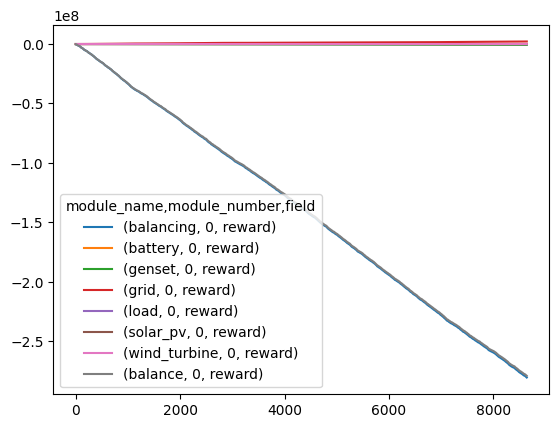

In [37]:
microgrid.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
plt.show()

In [38]:
microgrid.log.to_csv("random_272.csv")

In [39]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 26)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

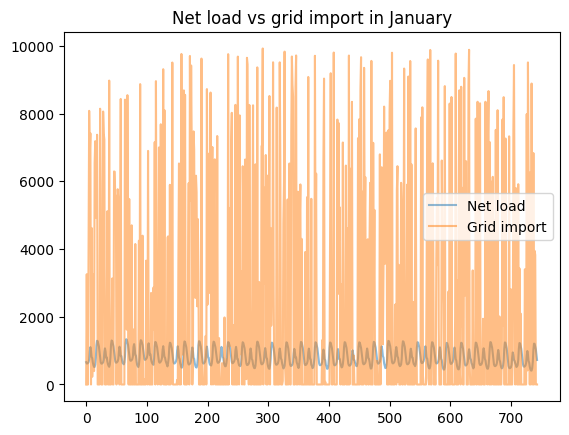

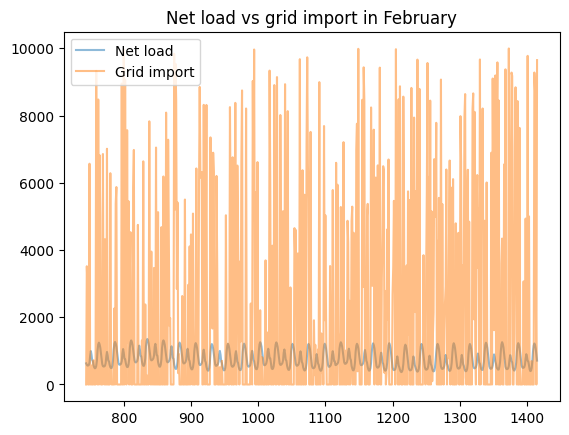

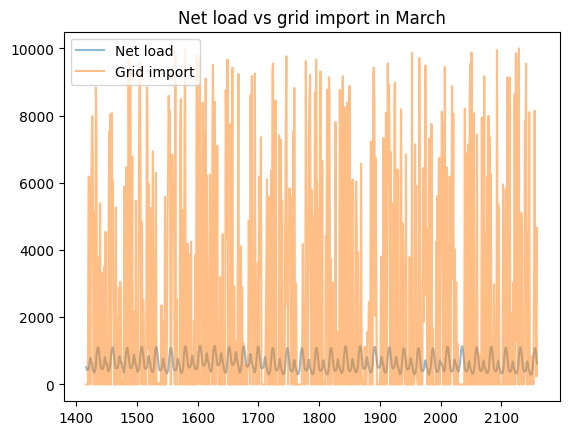

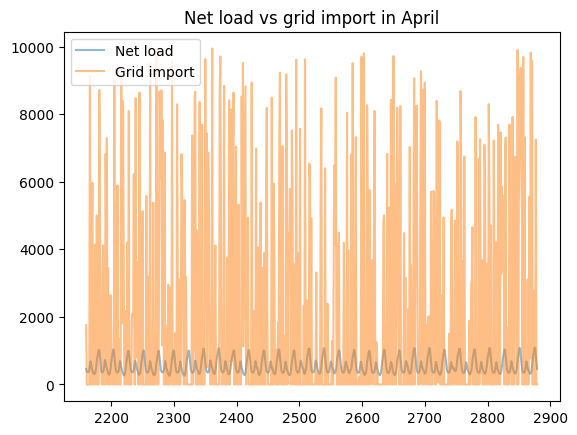

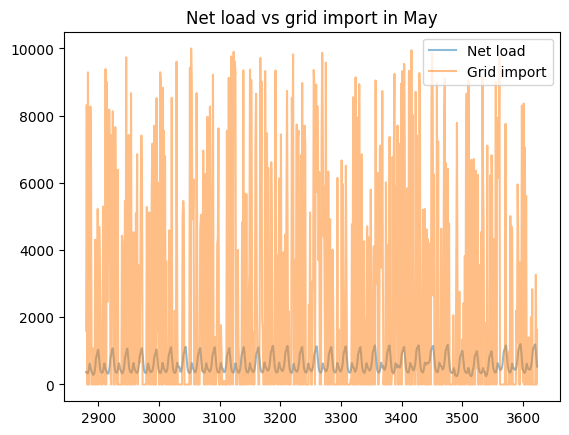

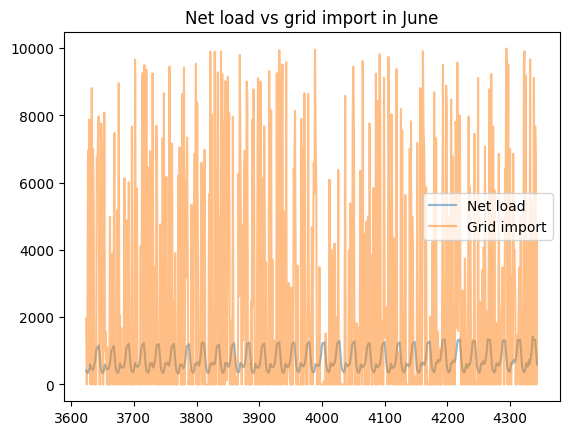

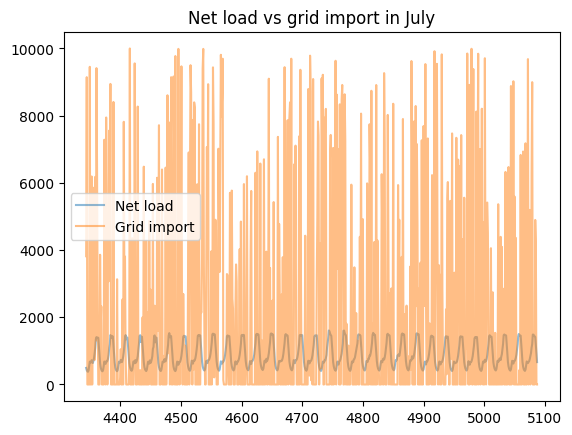

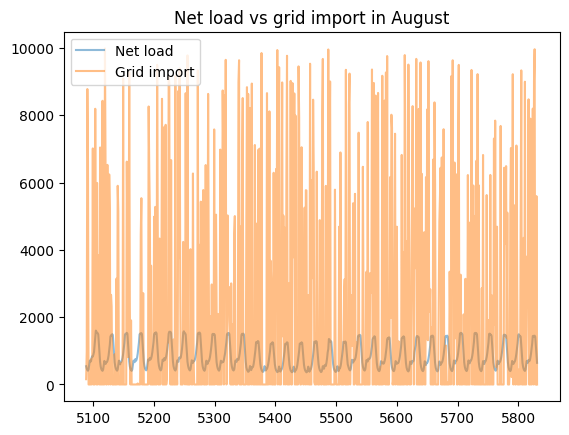

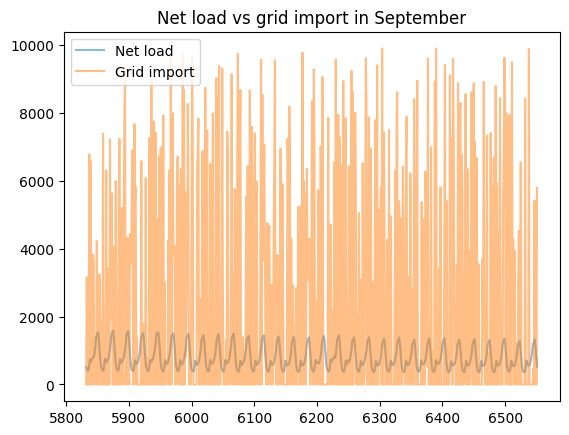

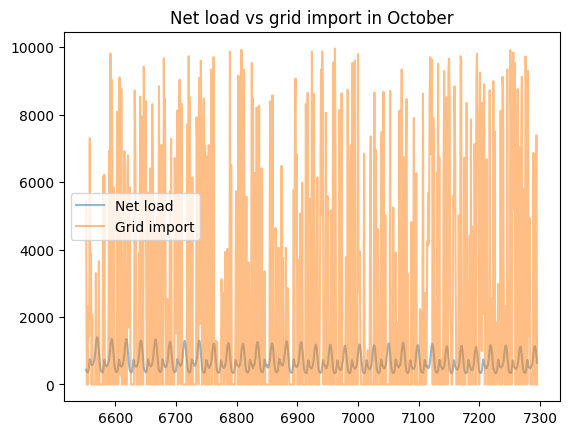

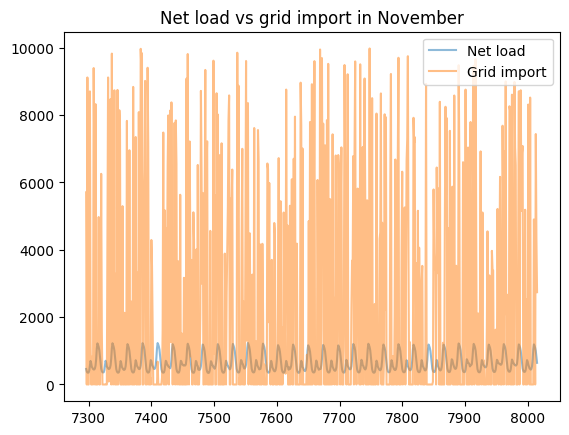

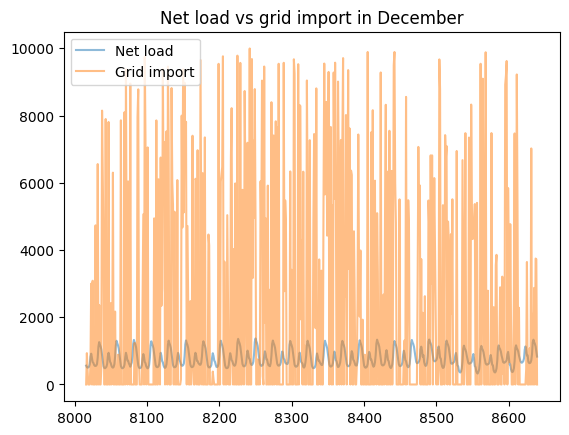

In [40]:
load_less_renewable_available = microgrid.log[('load', 0, 'load_met')] - microgrid.log[('solar_pv', 0, 'renewable_current')]
grid_import = microgrid.log[('grid', 0, 'grid_import')]

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load_less_renewable_available, grid_import],
              keys=['Net load', 'Grid import'],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

### Rule-based

In [41]:
microgrid = Microgrid(modules=modules)
rbc = RuleBasedControl(microgrid)

In [42]:
rbc.reset()
rbc_result = rbc.run()

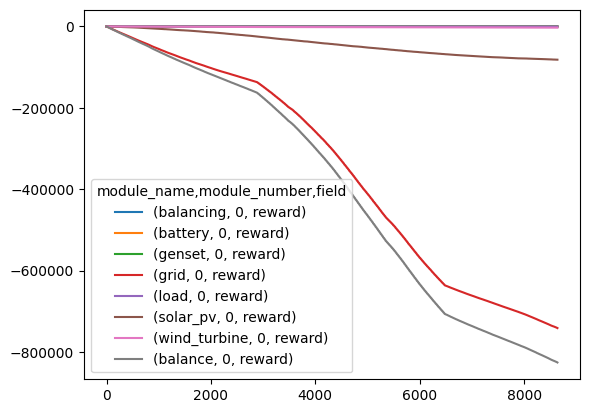

In [43]:
rbc_result.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
plt.show()

In [44]:
print(f"Total overgeneration or loss load costs over the course of the year:\n\
{rbc_result.loc[:, pd.IndexSlice['balancing', :, 'reward']].sum().item()}")

Total overgeneration or loss load costs over the course of the year:
-1.2611736495090654e-09


In [45]:
rbc_result.to_csv("rbc_272.csv")

In [46]:
days_in_month = [
    ('January', 31),
    ('February', 28),
    ('March', 31),
    ('April', 30),
    ('May', 31),
    ('June', 30),
    ('July', 31),
    ('August', 31),
    ('September', 30),
    ('October', 31),
    ('November', 30),
    ('December', 26)
]

month_start_end_dates = {days_in_month[0][0]: [0, 24 * days_in_month[0][1]]}

for month_n, (month, days_in) in enumerate(days_in_month[1:], start=1):
    last_end = month_start_end_dates[days_in_month[month_n-1][0]][-1]
    month_start_end_dates[month] = [last_end, 24 * days_in + last_end]

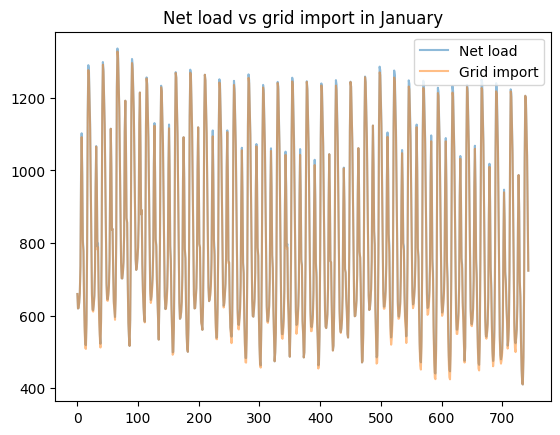

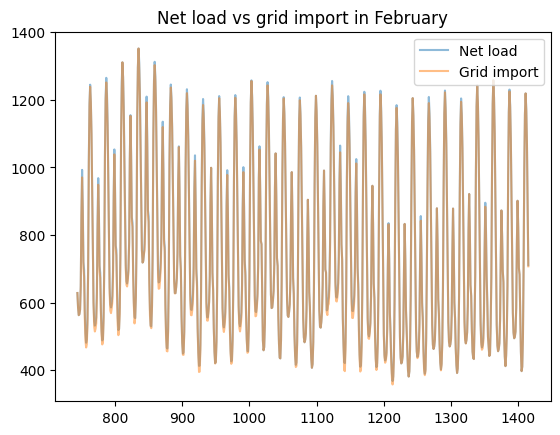

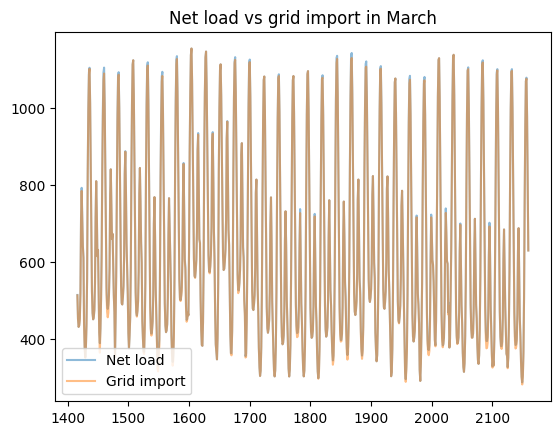

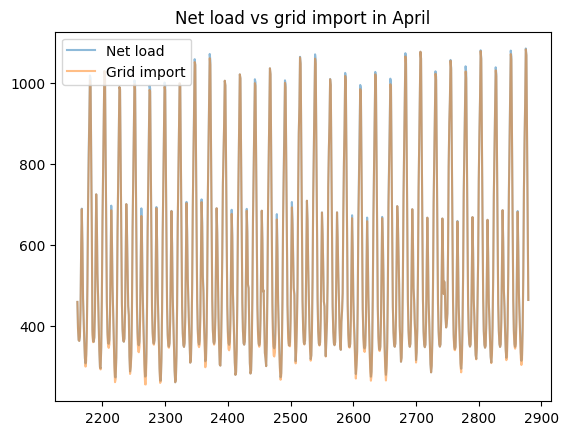

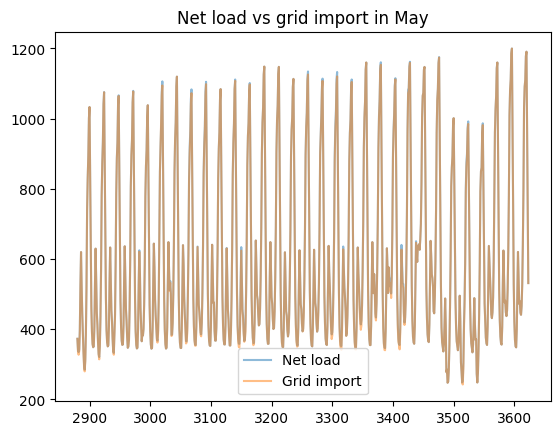

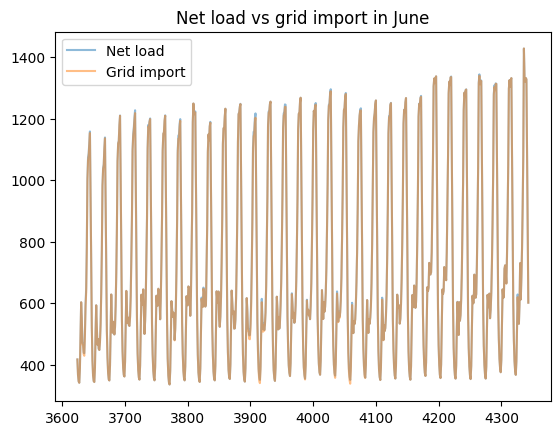

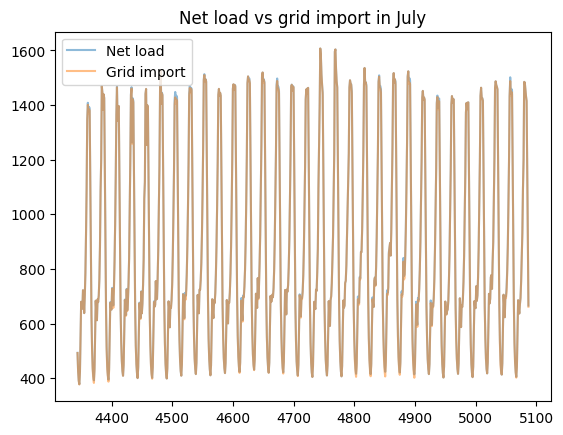

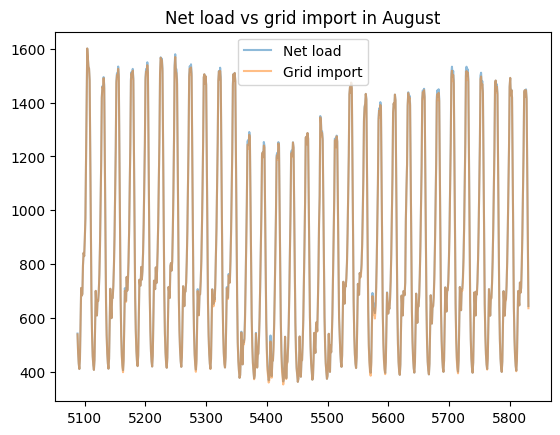

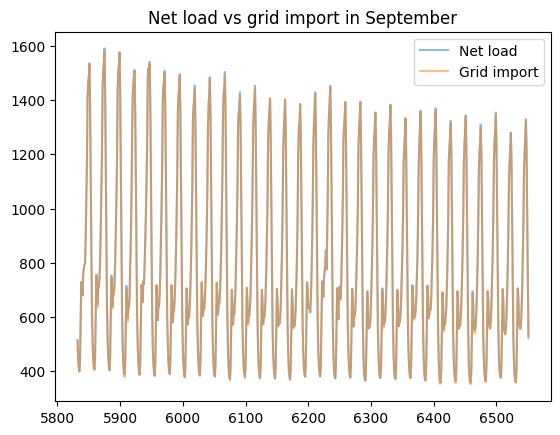

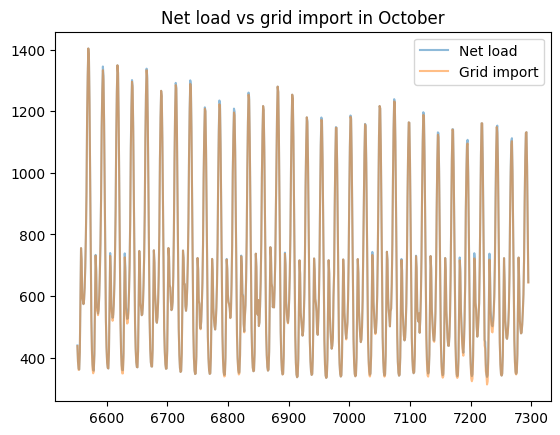

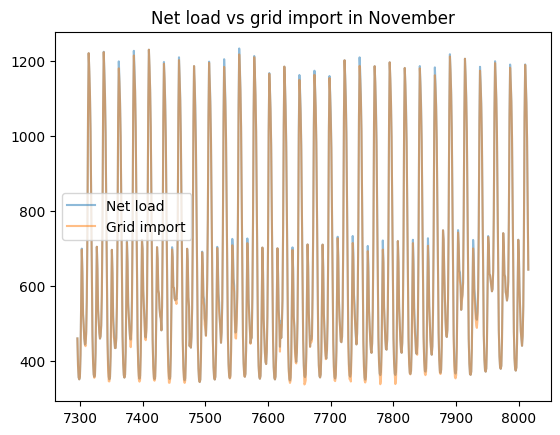

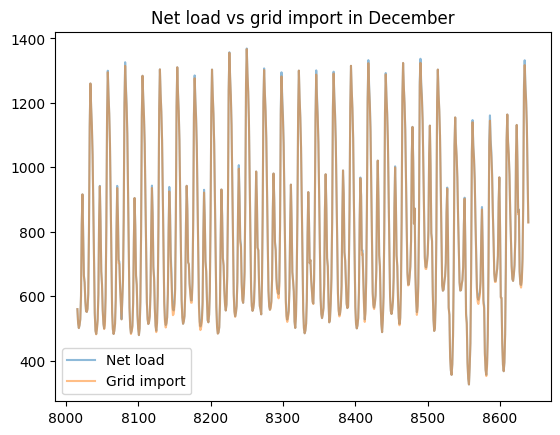

In [47]:
load_less_renewable_available = rbc_result[('load', 0, 'load_met')] - rbc_result[('solar_pv', 0, 'renewable_current')]
grid_import = rbc_result[('grid', 0, 'grid_import')]

for month, (start_hour, end_hour) in month_start_end_dates.items():

    pd.concat([load_less_renewable_available, grid_import],
              keys=['Net load', 'Grid import'],
              axis=1).iloc[start_hour:end_hour].plot(alpha=0.5, title=f'Net load vs grid import in {month}')

    plt.show()

### Reinforcement Learning